# _*Qiskit Aqua: Amplitude Estimation*_ 


***
### Contributors
Stefan Woerner<sup>[1]</sup>, Daniel Egger<sup>[1]</sup>, Shaohan Hu<sup>[1]</sup>, Stephen Wood<sup>[1]</sup>, Marco Pistoia<sup>[1]</sup>

Adapted by Sergio Gago
### Affiliation
- <sup>[1]</sup>IBMQ

### Introduction
<br>
This notebook illustrates amplitude estimation in the simplest case, where the (assumed to be unknown) success probability $p$ of a Bernoulli random variable is estimated.
In other words, we assume a qubit is prepared in a state $\sqrt{1-p}\,\big|0\rangle + \sqrt{p}\,\big|1\rangle$, i.e., the probability of measuring $\big|1\rangle$ equals $p$.
This matches the results that have been demonstrated on real hardware in [1].
<br>
<br>
Amplitude estimation uses two operators: $A$ and $Q$, where $A$ describes the problem and $Q$ is derived from $A$ [2].
Here, $A = R_y(\theta_p)$, i.e., it equals a rotation with an angle $\theta_p = 2\sin^{-1}(\sqrt{p})$ around the Y-axis. For this single qubit case, $Q$ can  be represented by a Y-rotation around twice that angle, i.e., $Q = R_y(2\theta_p)$ [1]. 
This particularly implies that powers of the operator can be efficiently represented, i.e. $Q^k = R_y(2k\theta_p)$.
The result is then mapped into $m$ evaluation qubits. The larger $m$, the higher the accuracy of the estimation but also the longer the quantum circuit.
<br>
<br>
[1] <a href="https://arxiv.org/abs/1806.06893">Quantum Risk Analysis. Woerner, Egger. 2018.</a>
<br>
[2] <a href="https://arxiv.org/abs/quant-ph/0005055">Quantum Amplitude Amplification and Estimation. Brassard et al. 2000.</a>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit.tools.visualization import plot_bloch_vector
from qiskit import BasicAer, QuantumCircuit, QuantumRegister
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.aqua.algorithms.amplitude_estimators.q_factory import QFactory
from qiskit.aqua.components.uncertainty_problems import UncertaintyProblem

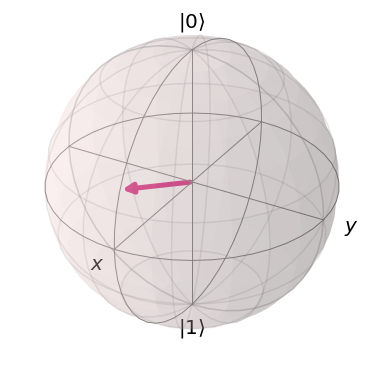

In [2]:
# the probability to be recovered
probability = 0.3
theta_p = 2*np.arcsin(np.sqrt(probability))

# the resulting quantum state after A is applied
plot_bloch_vector([np.sin(theta_p), 0.0, np.cos(theta_p)])

In [3]:
# construct factories for A. Q is automatically created by Qiskit AE. Using Grover's oracle
a_registry = QuantumRegister(1, 'q')
a_factory =  QuantumCircuit(a_registry)
a_factory.ry(theta_p, a_registry[0])

In [4]:
# set number of evaluation qubits
m = 6

# construct amplitude estimation
# here, we override the standard construction of Q since we know a more efficient way
# (exploiting the fact that A and Q are just Y-rotations)
ae = AmplitudeEstimation(m, a_factory)

In [5]:
# result = ae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'))
result = ae.run(quantum_instance=BasicAer.get_backend('statevector_simulator'))

In [6]:
result

{'a_estimation': 0.3086583, 'confidence_interval': [0.3000000047380006, 0.3000000047380006], 'estimation': 0.3086583, 'num_oracle_queries': 63, 'ml_value': 0.3000000047380006, 'mapped_a_samples': [0.0, 0.0024076, 0.0096074, 0.0215298, 0.0380602, 0.0590394, 0.0842652, 0.1134948, 0.1464466, 0.1828034, 0.2222149, 0.2643016, 0.3086583, 0.3548577, 0.4024548, 0.4509914, 0.5, 0.5490086, 0.5975452, 0.6451423, 0.6913417, 0.7356984, 0.7777851, 0.8171966, 0.8535534, 0.8865052, 0.9157348, 0.9409606, 0.9619398, 0.9784702, 0.9903926, 0.9975924, 1.0], 'probabilities': [0.0002611034420562687, 0.0005323943879291623, 0.0005644712046118999, 0.000623475236692352, 0.000719747857297056, 0.0008731750260061241, 0.0011232787059175652, 0.0015556129063438937, 0.00238248100467401, 0.004255823444149803, 0.010069156501281916, 0.049876299988314575, 0.8849444364623591, 0.02300676686337587, 0.006879910747776972, 0.0033011035801259496, 0.001958275815422061, 0.0013128262928077273, 0.0009538089300315099, 0.00073391519986

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/qiskit/aqua/algorithms/amplitude_estimators/ae.py:668: DeprecationWarning: values deprecated, use mapped_a_samples property.
  warnings.warn('values deprecated, use mapped_a_samples property.', DeprecationWarning)


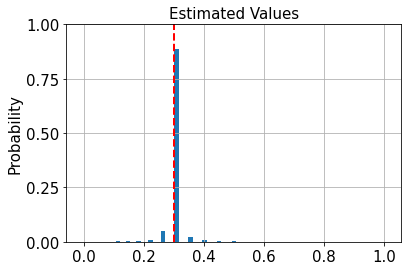

In [7]:
# plot estimated values
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.plot([probability, probability], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Values', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

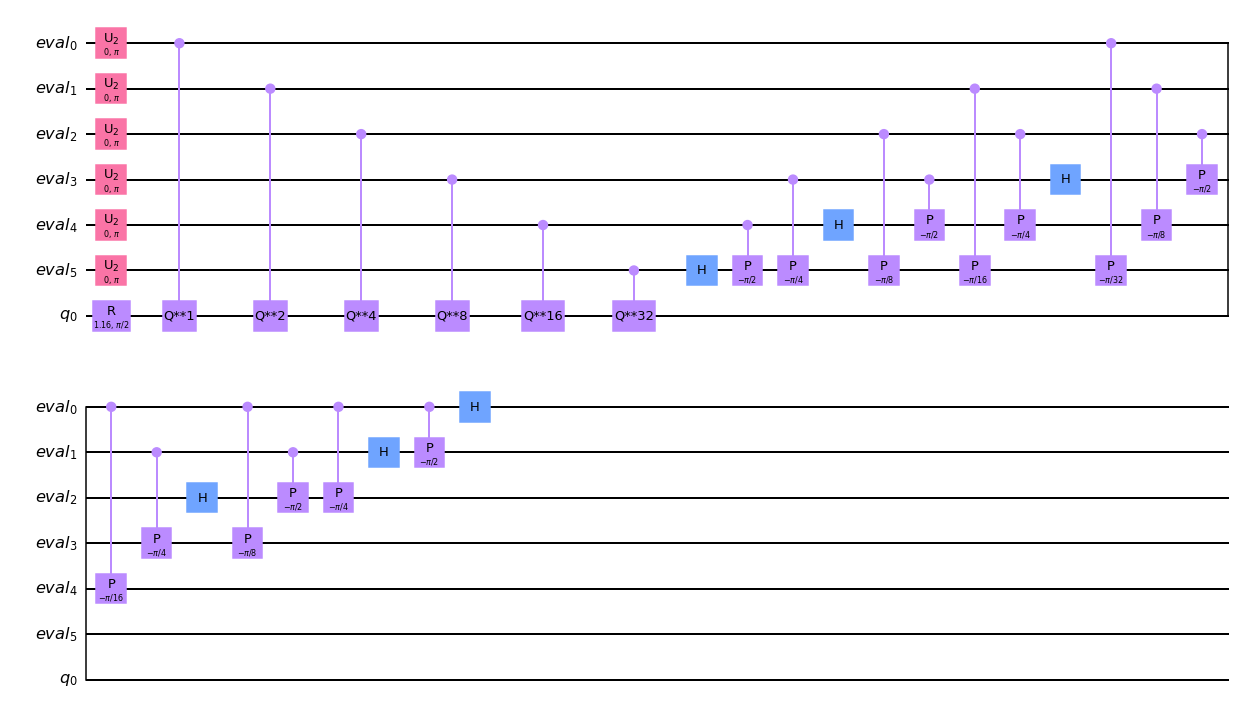

In [8]:
# plot circuit
ae._circuit.decompose().draw(output='mpl')

In [9]:
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation
epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
iae = IterativeAmplitudeEstimation(state_preparation=a_factory,
                                  epsilon=epsilon, alpha=alpha)
result = iae.run(quantum_instance=BasicAer.get_backend('qasm_simulator'), shots=100)

In [10]:
conf_int = np.array(result['confidence_interval'])
print('Estimated value:\t%.4f' % result['estimation'])
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

Estimated value:	0.3002
Confidence interval: 	[0.2961, 0.3043]
